# **Model Building Analysis** 
---
---

This notebook focuses on building a predictive machine learning model for breast cancer diagnosis using fine-needle aspiration (FNA) mass characteristics. The dataset contains a set of numeric features extracted from cell nuclei in digitized images, along with the corresponding diagnosis labels: **benign** or **malignant**.

The main objective is to accurately classify tumors based on these features, aiding early detection and supporting medical decision-making. The analysis includes:

- Model selection using repeated nested cross-validation
- Hyperparameter tuning
- Final model training 
- Development of an automated pipeline for the final model

All experiments ensure reproducibility with a fixed seed.

---
---

## 1. Repeated Nested Cross Validation

In this task, we will implement a Repeated Nested Cross-Validation (rnCV) framework to systematically evaluate and compare the generalization performance of multiple classification algorithms. We have created a Python class that encapsulates the rnCV logic, accepting the dataset, a list of estimators, their corresponding hyperparameter spaces, and configuration parameters for the outer and inner cross-validation loops (N=5, K=3) over R=10 repetitions. The design will ensure stratification is preserved to handle `class imbalance`, and all steps will be fully reproducible using fixed random seeds. 

During the inner loop, we will conduct hyperparameter tuning using an appropriate optimization metric, while in the outer loop, we will collect and report key evaluation metrics such as MCC, AUC, Balanced Accuracy, F1. Once the rnCV process is complete, we will analyze the results across all repetitions to determine the best-performing algorithm based on median metric values, considering 95% confidence intervals in cases of close performance. 

This analysis will support a robust and fair comparison of classifiers including Logistic Regression (Elastic Net), Gaussian Naive Bayes, LDA, SVM, Random Forest, and LightGBM.

In [9]:
# ------------- Setup and Imports ------------- 
import os
import sys
import numpy as np
import pandas as pd

sys.path.append('../')

from src.utils import *
from src.classes import *
from sklearn.svm import SVC
from lightgbm import LGBMClassifier
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import FunctionTransformer, RobustScaler
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis


# Seed for reproducibility
np.random.seed(42)

In [2]:
# ------------- Load Dataset -------------

scaled_bc = load_dataset("../data/breast_cancer_final_data.csv")

# ------------- Split target and features -------------
X, y = split_features_target(scaled_bc, "diagnosis")

# ------------- Directory for Saving Models -------------
os.makedirs("../models", exist_ok=True)

In [3]:
### ------------- REPEATED NESTED CROSS VALIDATION -------------

# Define the estimators
estimators = {
    "LogisticRegression": LogisticRegression(penalty='elasticnet', solver='saga', max_iter=10000),
    "GaussianNB": GaussianNB(),
    "LDA": LinearDiscriminantAnalysis(),
    "SVM": SVC(probability=True, verbose=False),
    "RandomForest": RandomForestClassifier(verbose=0),
    "LightGBM": LGBMClassifier(verbose=-1)
}

# Define the parameter grids for each estimator

param_grids = {
    "LogisticRegression": {
        'C': [0.1, 1],
        'l1_ratio': [0.0, 0.5]
    },
    "GaussianNB": {
        'var_smoothing': [1e-9, 1e-8]
    },
    "LDA": {
        'solver': ['svd', 'lsqr'],
        'shrinkage': [None, 'auto']
    },
    "SVM": {
        'C': [1, 10],
        'kernel': ['linear', 'rbf'],
        'gamma': ['scale']
    },
    "RandomForest": {
        'n_estimators': [100],
        'max_depth': [None, 10],
        'min_samples_split': [2],
        'min_samples_leaf': [1],
        'bootstrap': [True]
    },
    "LightGBM": {
        'num_leaves': [31],
        'learning_rate': [0.1],
        'n_estimators': [100],
        'max_depth': [-1],
        'reg_alpha': [0.0],
        'reg_lambda': [0.0]
    }
}

# Run Repeated Nested Cross-Validation

rncv = RepeatedNestedCV(
    X=X,
    y=y,
    estimators=estimators,
    param_grids=param_grids,
    repeats=10,
    outer_folds=5,
    inner_folds=3,
    random_state=42
)


# ------------- rnCV Results -------------
results_df = rncv.run()


metrics_df = rncv.summarize_results()
print(metrics_df)

ci_df = rncv.bootstrap_cis()
print(ci_df)



 Repeat 1/10
 Model: LogisticRegression
 Model: GaussianNB
 Model: LDA
 Model: SVM
 Model: RandomForest
 Model: LightGBM

 Repeat 2/10
 Model: LogisticRegression
 Model: GaussianNB
 Model: LDA
 Model: SVM
 Model: RandomForest
 Model: LightGBM

 Repeat 3/10
 Model: LogisticRegression
 Model: GaussianNB
 Model: LDA
 Model: SVM
 Model: RandomForest
 Model: LightGBM

 Repeat 4/10
 Model: LogisticRegression
 Model: GaussianNB
 Model: LDA
 Model: SVM
 Model: RandomForest
 Model: LightGBM

 Repeat 5/10
 Model: LogisticRegression
 Model: GaussianNB
 Model: LDA
 Model: SVM
 Model: RandomForest
 Model: LightGBM

 Repeat 6/10
 Model: LogisticRegression
 Model: GaussianNB
 Model: LDA
 Model: SVM
 Model: RandomForest
 Model: LightGBM

 Repeat 7/10
 Model: LogisticRegression
 Model: GaussianNB
 Model: LDA
 Model: SVM
 Model: RandomForest
 Model: LightGBM

 Repeat 8/10
 Model: LogisticRegression
 Model: GaussianNB
 Model: LDA
 Model: SVM
 Model: RandomForest
 Model: LightGBM

 Repeat 9/10
 Model: Lo

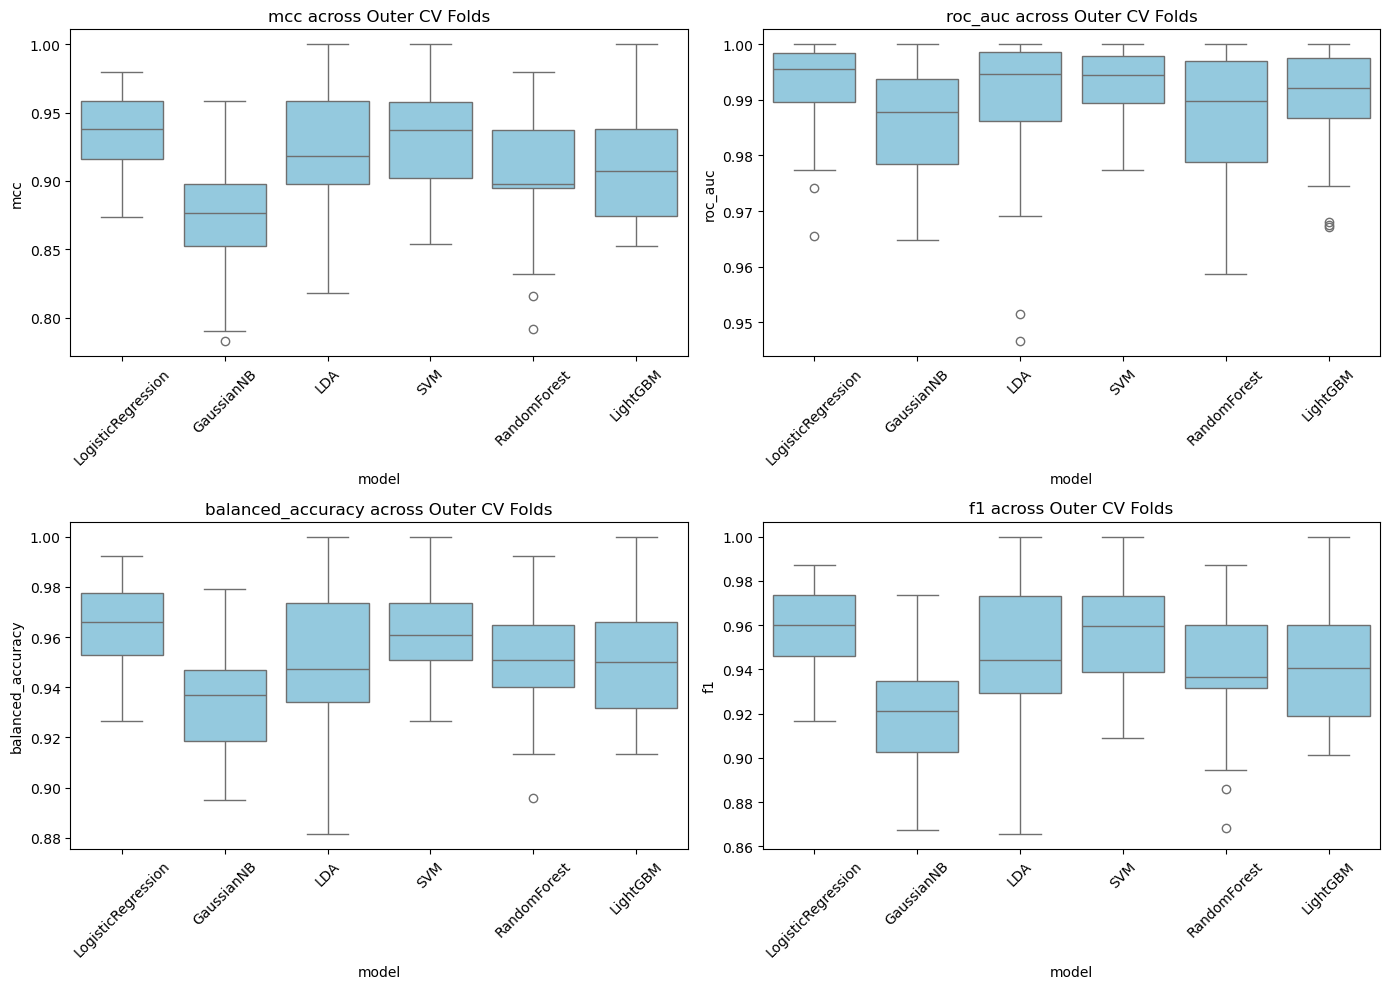

In [4]:
# ------------- Plotting Mean Metrics of Models -------------
rncv.plot_metric_boxplots('../figures/mean_metrics.png')  

***Logistic Regression*** emerged as the overall best-performing model, not only achieving the highest median and mean scores across most evaluation metrics (MCC, F1, ROC AUC, and balanced accuracy), but also demonstrating consistently strong performance under uncertainty. Its 95% confidence intervals were both high and narrow, indicating stable and reliable generalization: for example, the CI for MCC ranged from 0.937 to 0.949, and for F1 from 0.959 to 0.968. Compared to other models, no competitor surpassed Logistic Regression across multiple metrics when accounting for CI overlap, confirming it as the most robust and well-balanced choice for this classification task.

## 2. Hyperparameter Tuning for the Selected Model

In this task, we will train the final model by selecting the optimal hyperparameters for the winner algorithm, Logistic Regression. Using 5-fold cross-validation on the full dataset, we will evaluate the hyperparameter grid to identify the best-performing configuration for the final model instance.


In [5]:
### ------------- HYPERPARAMETER TUNING -------------

# Define the parameter grid for hyperparameter tuning
final_grid = {
    'C': [0.1, 0.5, 1, 2],
    'l1_ratio': [0.0, 0.25, 0.5, 0.75, 1.0]
}

# Run final CV using the `select_best_hyperparameters` function
final_model, final_params, final_results_hpt = select_best_hyperparameters(
    X=X, 
    y=y, 
    model=LogisticRegression(penalty='elasticnet', solver='saga', max_iter=10000),
    param_grid=final_grid,
    scoring='f1',
    cv=5,
    random_state=42
)
print("Results of HPT:\n", final_results_hpt)
print("Best hyperparameters:", final_params)


Results of HPT:
     mean_fit_time  std_fit_time  mean_score_time  std_score_time  param_C  \
0        0.080861      0.037715         0.010100        0.006681      0.1   
1        0.077020      0.015661         0.005220        0.000991      0.1   
2        0.101691      0.029655         0.004542        0.001575      0.1   
3        0.152234      0.044914         0.004254        0.000930      0.1   
4        1.092394      0.592733         0.004131        0.000616      0.1   
5        0.130306      0.017990         0.004216        0.000462      0.5   
6        0.199281      0.035738         0.003741        0.000619      0.5   
7        0.272084      0.045897         0.004375        0.001495      0.5   
8        0.384189      0.084155         0.003911        0.000659      0.5   
9        1.758524      0.501188         0.003539        0.000419      0.5   
10       0.199617      0.045589         0.003783        0.000378      1.0   
11       0.314772      0.080224         0.003542        0.0

The best hyperparameters for the final Logistic Regression model, selected via 5-fold cross-validation, were C = 0.5 and l1_ratio = 0.0, corresponding to an L2-regularized model with the highest mean test score across the evaluated grid.

## 3. Training and Saving the Winner Model 

The final Logistic Regression model, configured with the selected optimal hyperparameters, will be trained on the entire dataset and saved as a `.pkl` file in the `./models` directory, ready for deployment with full preprocessing and prediction capabilities on unseen data.


In [10]:
### ------------- TRAINING THE WINNER MODEL -------------


# 1. Load raw dataset
raw_data = load_dataset("../data/breast_cancer.csv")

# 2. Split features and target
X, y = split_features_target(raw_data, "diagnosis")

# 3. Encode labels
y = label_encode(y)

# 4. Preprocessing pipeline
preprocessing = Pipeline(steps=[
    ('imputer', FunctionTransformer(handling_missing_values)),
    ('log1p', FunctionTransformer(func=np.log1p, validate=False)),
    ('scaler', RobustScaler())
])

# 5. Full pipeline
pipeline = Pipeline(steps=[
    ('preprocessing', preprocessing),
    ('classifier', LogisticRegression(
        penalty='elasticnet', 
        solver='saga',
        C=0.5,
        l1_ratio=0.0, 
        max_iter=10000,
        random_state=42))
])

# 6. Train the model
winner = train_model(X, y, pipeline)


# 7. Save model
save_model(winner, "../models/winner.pkl")

---
---
